# Readme

Cross validation for the 'rnn 9 - 2' model.

# Setup

In [1]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import time
import random
import pickle
import json
import itertools
import importlib
import os

/home/mmip/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import sys
sys.path.append ('functions')

import functions as mf
importlib.reload(mf) 

from rnn_module import AmmoniaRNN

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [4]:
pd.set_option("display.max_columns", None)

# Data processing

## Data embeddings

In [5]:
data_embeddings = pd.read_csv("../00_data_preparation/processed_data/data_rnn_3.csv")

In [6]:
data_embeddings = data_embeddings[(data_embeddings['dt'] == 2) & (data_embeddings['interpolation'] == 'yes')]

In [7]:
data_embeddings = data_embeddings.drop(['Unnamed: 0'], axis = 1)

In [8]:
data_embeddings.shape

(39968, 22)

In [9]:
data_embeddings.head (2)

,e.cum,delta_e.cum,e.cum_shift,dt,dt_origin,inst,pmid,country,meas.tech,ct,air.temp,wind.2m,rain.rate,tan.app,app.mthd,app.rate,man.dm,man.ph,man.source,incorp,t.incorp,interpolation
0,3.574,3.574,0.000,2.0,4.0,104,182,DK,micro met,2.0,8.2,8.1,0.0,122.11,0,31.8,3.7,7.35,0,0,1000.0,yes
1,7.148,3.574,3.574,2.0,4.0,104,182,DK,micro met,4.0,8.2,8.1,0.0,122.11,0,31.8,3.7,7.35,0,0,1000.0,yes


## Test samples

In [10]:
with open("../00_data_preparation/processed_data/list_train_pmids.json", "r") as f:
    list_train_pmids = json.load(f)

with open("../00_data_preparation/processed_data/list_eval_pmids.json", "r") as f:
    list_eval_pmids = json.load(f)

with open("../00_data_preparation/processed_data/list_test_pmids.json", "r") as f:
    list_test_pmids = json.load(f)

In [11]:
len (list_train_pmids)

15

# Cross validation

In [12]:
response = ["delta_e.cum"]
bidirectional = [True]
mlp = [True]
with_embeddings = [True]
num_params = [None]

hyper_grid = pd.DataFrame(
    itertools.product(response, bidirectional, mlp, with_embeddings, num_params), 
    columns=["response", "bidirectional", "mlp", "with_embeddings", "num_params"]
)

hyper_grid.insert(0, "model", range(1, len(hyper_grid) + 1))

hyper_grid.style.hide(axis="index")

model,response,bidirectional,mlp,with_embeddings,num_params
1,delta_e.cum,True,True,True,None


In [13]:
p = 15

In [14]:
folder_path = "results/05_2_model_comparison_with_interpolation/df_res"

df_list = []

for file in os.listdir(folder_path):
    if file.endswith(".csv"):  
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)  
        df_list.append(df)

df_all_predictions = pd.concat(df_list, ignore_index=True)

In [15]:
df_all_predictions.shape

(63890, 14)

In [16]:
df_all_predictions.head (2)

,sample,model,n_parameters,pmid,e.cum,delta_e.cum,ct,dt,air.temp,wind.2m,rain.rate,prediction_ecum,prediction_delta_ecum,running_time
0,11,1,569450,190,4.981647,4.981647,2.0,2.0,12.52,4.02,0.047059,4.323069,4.323069,89.290744
1,11,1,569450,190,9.963294,4.981647,4.0,2.0,12.52,4.02,0.047059,7.836523,3.513454,89.290744


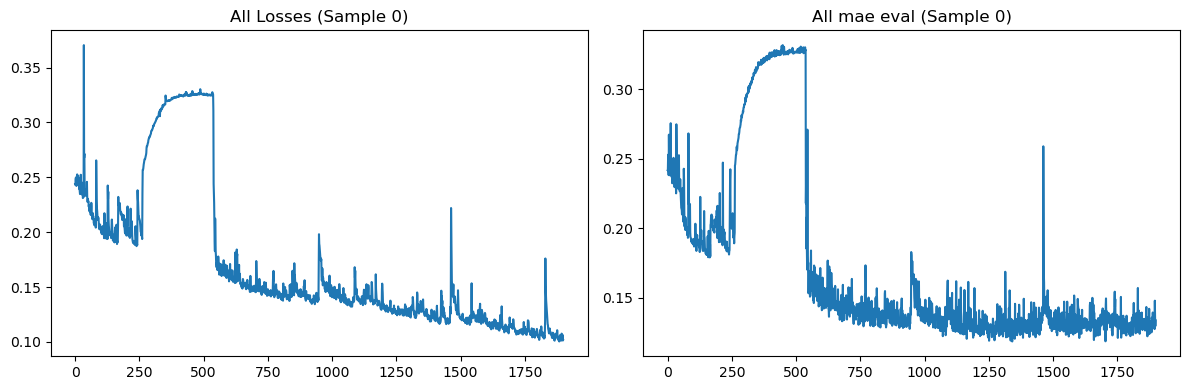

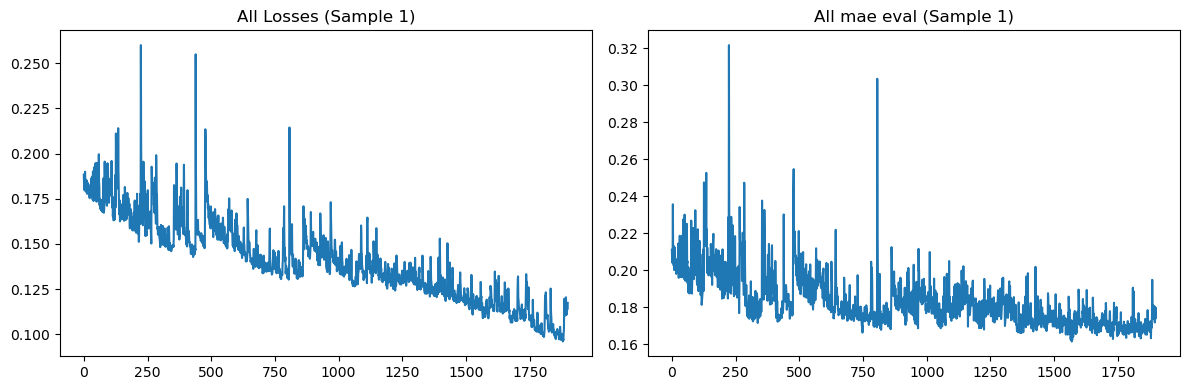

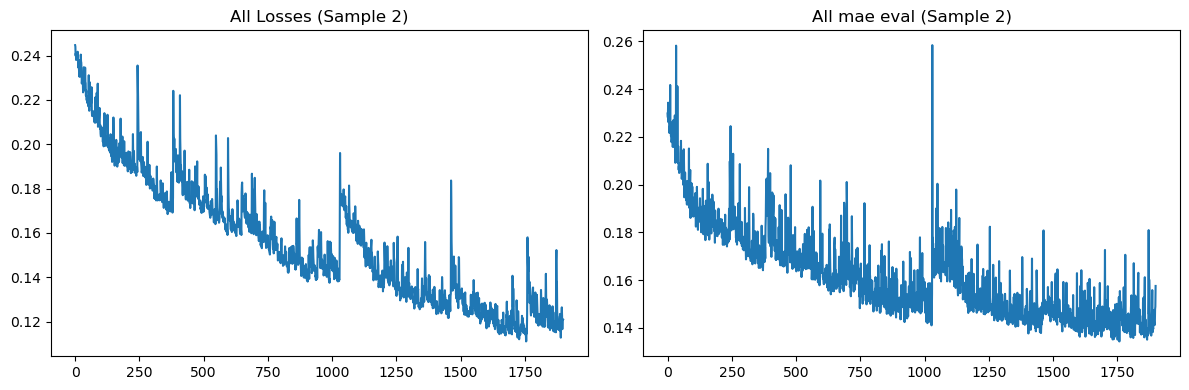

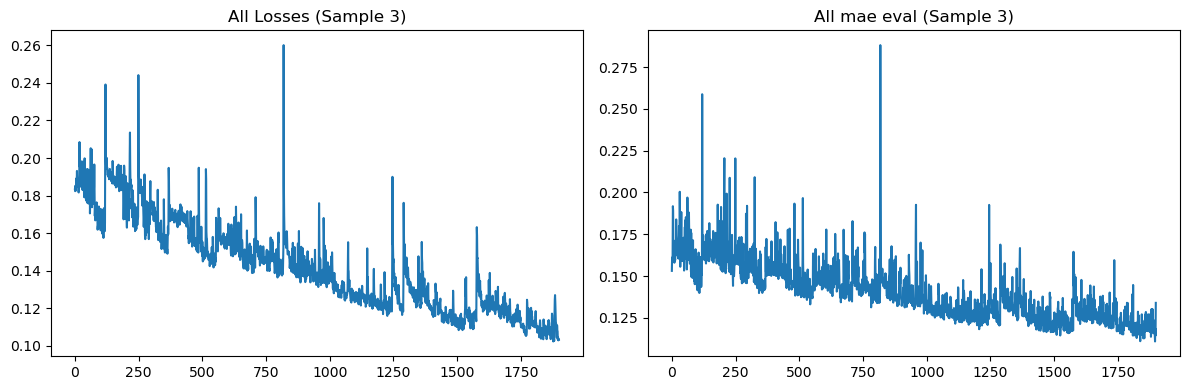

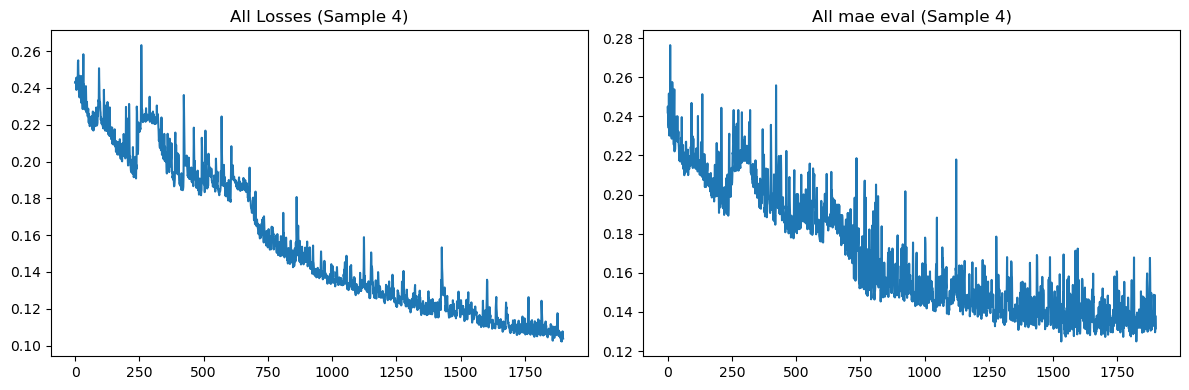

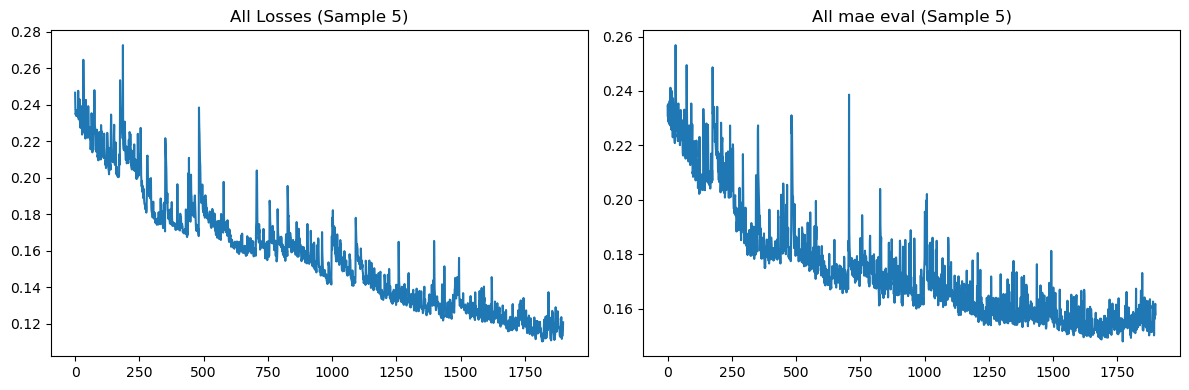

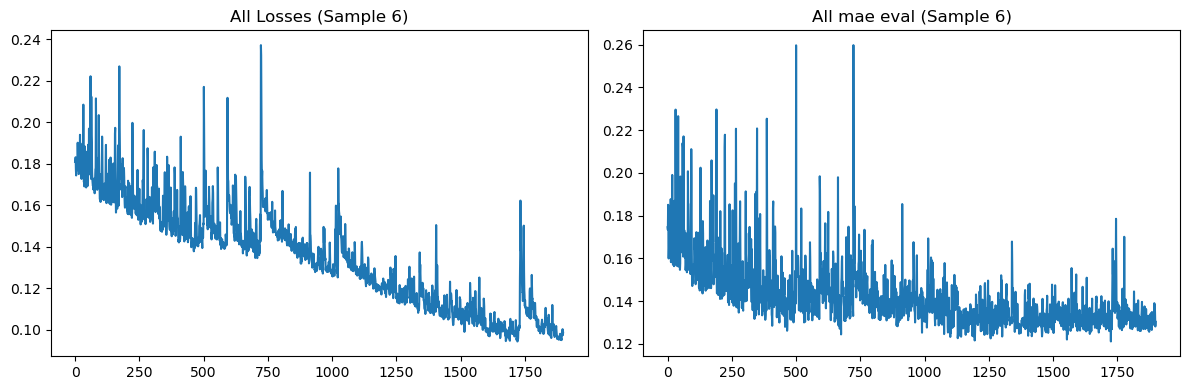

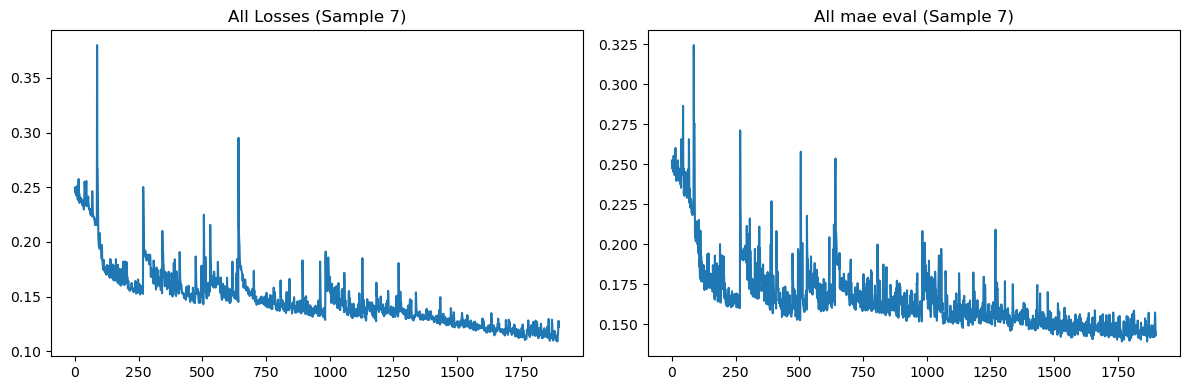

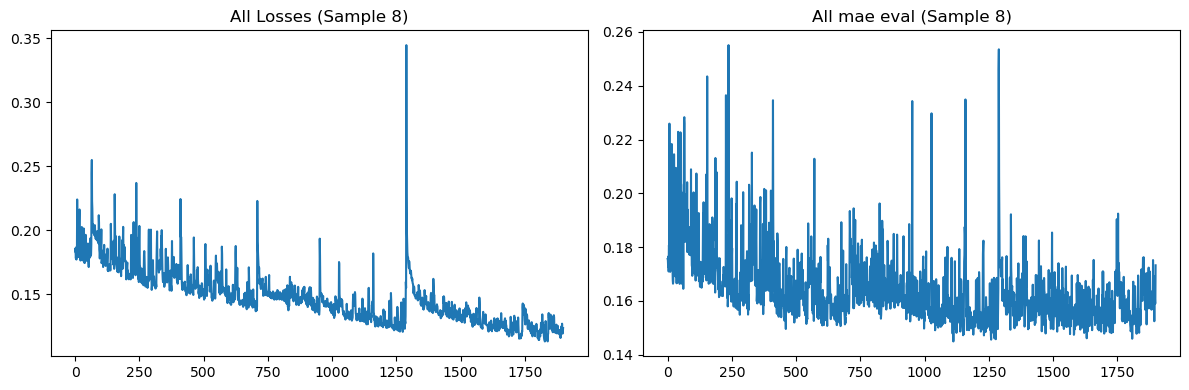

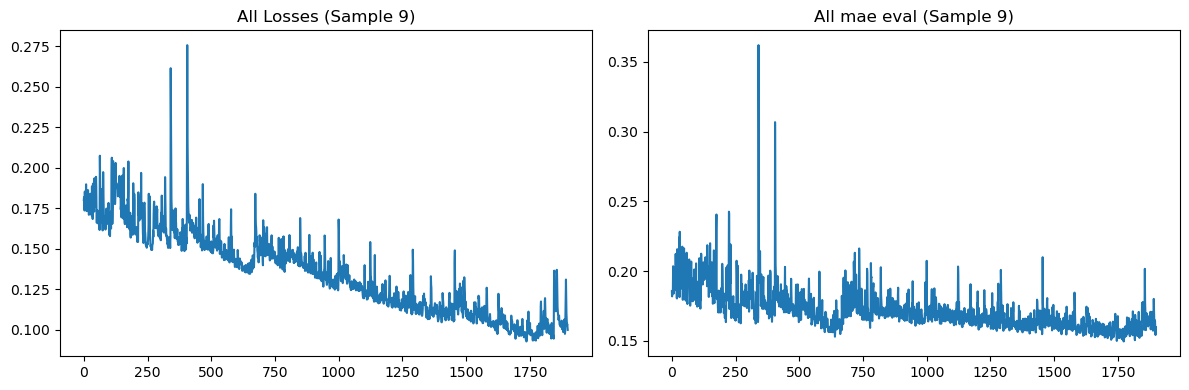

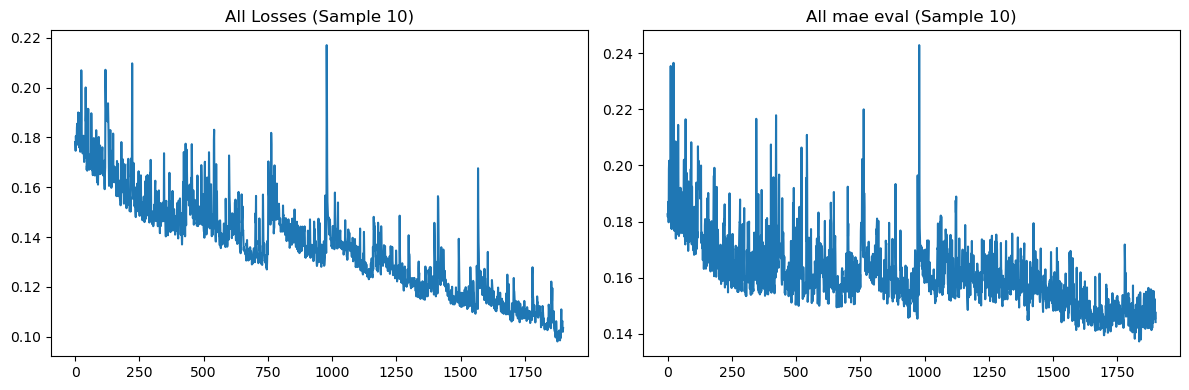

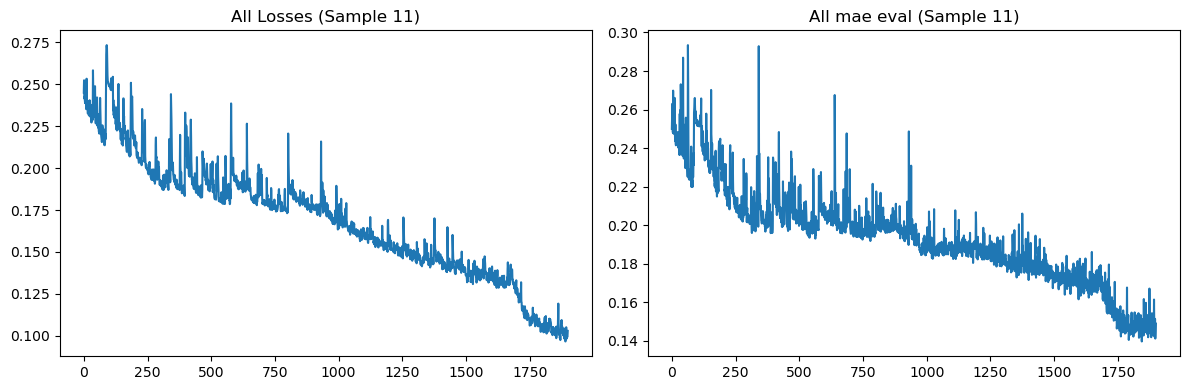

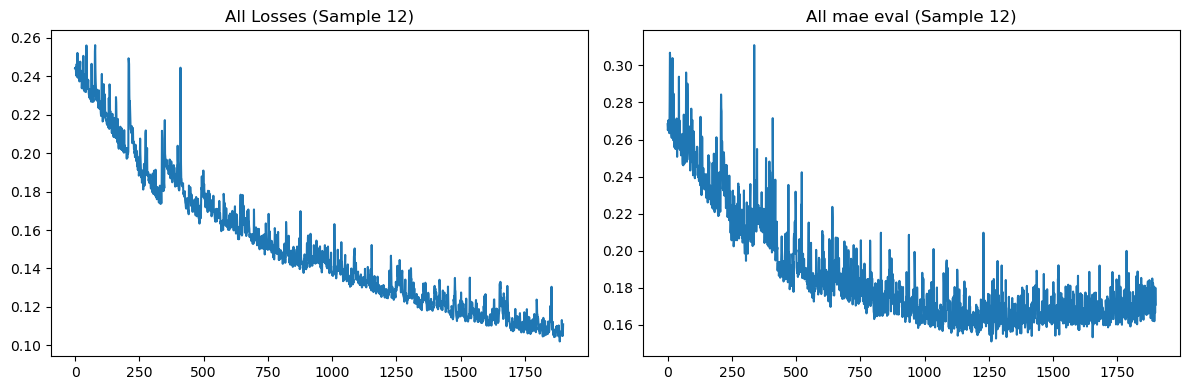

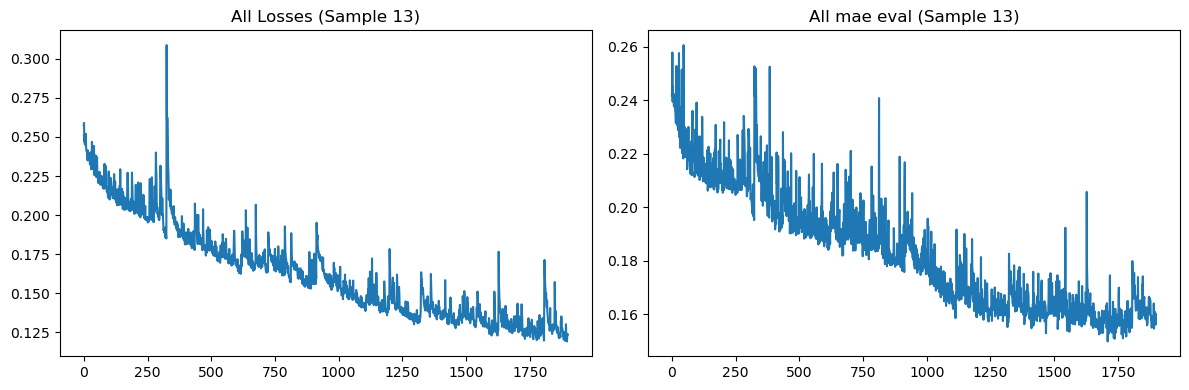

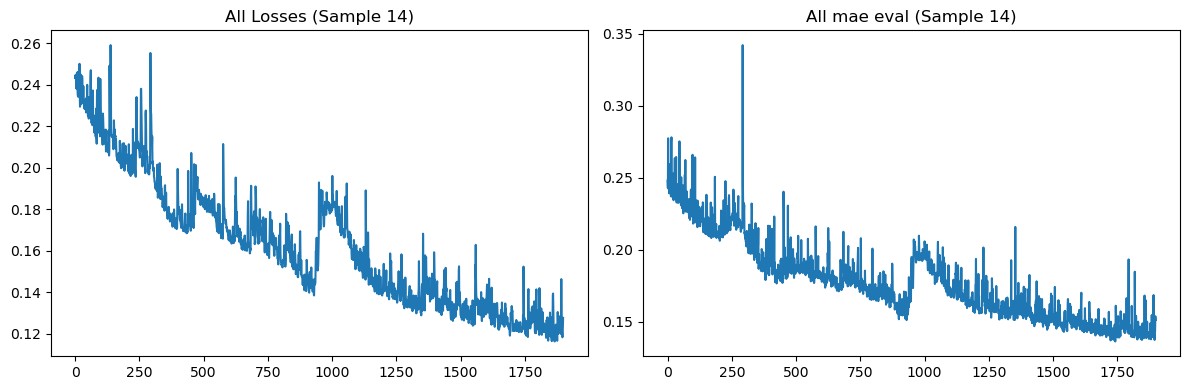

In [17]:
model_index = 1

for sample in range (15):

    with open(f'results/05_2_model_comparison_with_interpolation/all_mae_eval/all_mae_eval_sample_{sample}_model_{model_index}.pkl', "rb") as f:
        all_mae_eval = pickle.load(f)

    with open(f'results/05_2_model_comparison_with_interpolation/all_losses/all_losses_sample_{sample}_model_{model_index}.pkl', "rb") as f:
        all_losses = pickle.load(f)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

    axes[0].plot(all_losses[100:])
    axes[0].set_title(f'All Losses (Sample {sample})')

    axes[1].plot(all_mae_eval[100:])
    axes[1].set_title(f'All mae eval (Sample {sample})')

    plt.tight_layout()

    plt.show()

# End